<a href="https://colab.research.google.com/github/Sharmiladevarajan/My-Portfolio/blob/main/Pandas_async_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install -q httpx
import time
import math
import random
import asyncio
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# For reproducibility Setting seed(45) guarantees that the specific sequence of "random" numbers your program generates will be exactly the same every time you run the code. The number 45 itself is an arbitrary starting point that ensures this consistent, reproducible outcome.
np.random.seed(42)
random.seed(42)


# --- PARAMETERS (easy to change) ---
NUM_CUSTOMERS = 10000     # start with 10k for Colab example; you can scale to 1M locally
NUM_ORDERS = 50000
NUM_VIPS = 1000

# Generate customers dataframe
customers = pd.DataFrame({
    "customer_id": np.arange(10000, 10000 + NUM_CUSTOMERS),
    "name": np.random.choice(["Alice", "Bob", "Charlie", "David", "Eve", "Fiona", "Gita"], size=NUM_CUSTOMERS),
    "email": [f"user{i}@example.com" for i in range(NUM_CUSTOMERS)],
    "signup_date": pd.to_datetime("2020-01-01") + pd.to_timedelta(np.random.randint(0, 1500, size=NUM_CUSTOMERS), unit="d"),
    "total_spent": np.round(np.random.uniform(100, 30000, size=NUM_CUSTOMERS), 2),
    "loyalty_points": np.random.randint(0, 5000, size=NUM_CUSTOMERS)
})
# pd.DataFrame() (Pandas function):
# Purpose: The primary constructor used to assemble all the generated lists and arrays into a structured, tabular data format called a DataFrame (like an Excel table).
# np.arange() (NumPy function):
# Purpose: Generates evenly spaced values within a given interval. In the code, it's used to create a sequential list of unique customer IDs (e.g., 10000, 10001, 10002...).
# np.random.choice() (NumPy function):
# Purpose: Randomly selects items from a specified list of options. It's used here to assign random names from the list of seven names provided ("Alice", "Bob", etc.) to each customer.
# pd.to_datetime() (Pandas function):
# Purpose: Converts input into a proper datetime object. It sets the fixed starting date "2020-01-01" as the baseline for all signup dates.
# pd.to_timedelta() (Pandas function):
# Purpose: Represents a duration of time (a difference between two times). It converts the random number of days generated by np.random.randint into a time duration that can be added to the base date.
# np.random.randint() (NumPy function):
# Purpose: Generates random integers (whole numbers) within a specified range. Used twice:
# To generate a random number of days to add to the signup date.
# To generate random loyalty point totals.
# np.random.uniform() (NumPy function):
# Purpose: Generates random floating-point numbers (numbers with decimals) within a specified low and high range. Used to simulate realistic, varied total_spent currency amounts.
# np.round() (NumPy function):
# Purpose: Rounds the elements of an array to a specified number of decimal places. Used to format the total_spent values to two decimal places (like dollars and cents).

customers.to_csv("customers.csv", index=False)
print(f"customers.csv written with {len(customers)} rows")


orders = pd.DataFrame({
    "order_id": np.arange(1, NUM_ORDERS + 1),
    "customer_id": np.random.choice(customers["customer_id"], size=NUM_ORDERS),
    "order_amount": np.round(np.random.uniform(10, 1000, size=NUM_ORDERS), 2),
    "order_date": pd.to_datetime("2021-01-01") + pd.to_timedelta(np.random.randint(0, 1000, size=NUM_ORDERS), unit="d"),
    "status": np.random.choice(["delivered", "cancelled", "refunded"], size=NUM_ORDERS, p=[0.8, 0.1, 0.1])
})

orders.to_csv("orders.csv", index=False)
print(f"orders.csv written with {len(orders)} rows")


# Create VIP list (random subset)
vip_list = list(np.random.choice(customers["customer_id"].values, size=NUM_VIPS, replace=False))
print(f"VIP list created with {len(vip_list)} ids")

display(customers.head())
display(orders.head())
display(vip_list[5:10])

customers.csv written with 10000 rows
orders.csv written with 50000 rows
VIP list created with 1000 ids


,customer_id,name,email,signup_date,total_spent,loyalty_points
0,10000,Gita,user0@example.com,2023-01-31,23380.18,1380
1,10001,David,user1@example.com,2020-10-23,7536.34,2175
2,10002,Eve,user2@example.com,2022-09-28,20377.66,2405
3,10003,Gita,user3@example.com,2020-06-26,27075.60,3363
4,10004,Charlie,user4@example.com,2023-05-23,11633.40,3426


,order_id,customer_id,order_amount,order_date,status
0,1,19800,333.55,2021-05-28,cancelled
1,2,11081,818.04,2021-01-19,delivered
2,3,16639,893.50,2023-06-23,delivered
3,4,17018,285.45,2023-07-22,delivered
4,5,16105,288.64,2021-08-23,delivered


[np.int64(16119),
 np.int64(16869),
 np.int64(19022),
 np.int64(11116),
 np.int64(14451)]

In [8]:
# 2 — VIP Tagging: 3 Methods + Benchmarking (Colab cell 2)
from time import perf_counter
# The function perf_counter (short for performance counter) is used to measure how long a specific section of code takes to run with the highest possible accuracy.
def method_a_list_apply(df, vip_list):
    # Baseline: list + apply (slow)
    start = perf_counter()
    df_copy = df.copy()
    df_copy['is_vip'] = df_copy['customer_id'].apply(lambda x: x in vip_list)
    elapsed = perf_counter() - start
    return df_copy, elapsed

def method_b_set_apply(df, vip_list):
    # Convert list->set, still using apply
    start = perf_counter()
    vip_set = set(vip_list)
    df_copy = df.copy()
    df_copy['is_vip'] = df_copy['customer_id'].apply(lambda x: x in vip_set)
    elapsed = perf_counter() - start
    return df_copy, elapsed

def method_c_vectorized_isin(df, vip_list):
    # Vectorized pandas isin (fast)
    start = perf_counter()
    df_copy = df.copy()
    df_copy['is_vip'] = df_copy['customer_id'].isin(vip_list)
    elapsed = perf_counter() - start
    return df_copy, elapsed

# Run benchmarks
print("Running VIP tagging benchmarks (this may take a few seconds)...")
res_a_df, t_a = method_a_list_apply(customers, vip_list)
res_b_df, t_b = method_b_set_apply(customers, vip_list)
res_c_df, t_c = method_c_vectorized_isin(customers, vip_list)

print("\nVIP Tagging Benchmark Results:")
print(f"Method A (list + apply):     {t_a:.4f} seconds")
print(f"Method B (set + apply):      {t_b:.4f} seconds")
print(f"Method C (vectorized isin):  {t_c:.4f} seconds")

# Basic sanity check (all methods must produce same is_vip column)
assert (res_a_df['is_vip'].equals(res_b_df['is_vip']))
assert (res_a_df['is_vip'].equals(res_c_df['is_vip']))
print("Sanity check passed: all methods produce identical results.")


Running VIP tagging benchmarks (this may take a few seconds)...

VIP Tagging Benchmark Results:
Method A (list + apply):     0.5367 seconds
Method B (set + apply):      0.0038 seconds
Method C (vectorized isin):  0.0050 seconds
Sanity check passed: all methods produce identical results.


In [10]:
# Cell 3 — Async enrichment (simulated API) with concurrency, caching, retries
!pip install nest_asyncio
import httpx
import asyncio
from time import perf_counter
import nest_asyncio
nest_asyncio.apply()
# --- CONFIG ---
MAX_CONCURRENCY = 100  # number of concurrent requests allowed
SIMULATED = True       # True -> simulated API; False -> call real API (see notes below)
SIMULATED_LATENCY_MS = (50, 300)  # min,max latency per request in milliseconds
MAX_RETRIES = 3

# If using a real API, set REAL_API_BASE (example: "https://api.example.com/customers")
REAL_API_BASE = "https://fake-json-api.mock.beeceptor.com/users"  # example (may not work from Colab)

# --- Enrichment logic ---
class Enricher:
    def __init__(self, concurrency=MAX_CONCURRENCY, simulated=True):
        self.sem = asyncio.Semaphore(concurrency)
        self.simulated = simulated
        self.cache = {}  # simple in-memory cache: customer_id -> metadata

    async def _simulate_call(self, customer_id):
        # Simulate variable network latency and return fake metadata
        latency = random.randint(SIMULATED_LATENCY_MS[0], SIMULATED_LATENCY_MS[1]) / 1000
        await asyncio.sleep(latency)  # simulate network IO
        # create random metadata (score 0-100)
        return {"customer_id": int(customer_id), "score": random.randint(0, 100), "last_updated": datetime.utcnow().isoformat()}

    async def _real_call(self, client, customer_id):
        # Example real call (adjust path/query as needed)
        resp = await client.get(f"{REAL_API_BASE}", params={"customer_id": customer_id}, timeout=10.0)
        resp.raise_for_status()
        # Suppose API returns JSON with a 'score' field
        data = resp.json()
        # Map / normalize to our schema; this depends on API
        return {"customer_id": int(customer_id), "score": data.get("score", random.randint(0, 100)), "last_updated": datetime.utcnow().isoformat()}

    async def fetch_one(self, client, customer_id):
        # Use cache
        if customer_id in self.cache:
            return self.cache[customer_id]

        # Acquire semaphore for concurrency control
        async with self.sem:
            # Retry loop
            for attempt in range(1, MAX_RETRIES + 1):
                try:
                    if self.simulated:
                        result = await self._simulate_call(customer_id)
                    else:
                        result = await self._real_call(client, customer_id)
                    # Save to cache
                    self.cache[customer_id] = result
                    return result
                except Exception as e:
                    wait_time = 0.5 * (2 ** (attempt - 1))  # exponential backoff
                    print(f"Error fetching {customer_id} (attempt {attempt}): {e}; retrying in {wait_time}s")
                    await asyncio.sleep(wait_time)
            # if all retries exhausted:
            print(f"Failed to fetch metadata for {customer_id} after {MAX_RETRIES} retries.")
            self.cache[customer_id] = {"customer_id": int(customer_id), "score": None, "last_updated": None}
            return self.cache[customer_id]

    async def enrich_many(self, customer_ids, concurrency=None):
        # customer_ids: iterable
        results = {}
        # Create one shared AsyncClient (if real calls)
        async with httpx.AsyncClient() if not self.simulated else dummy_client_context():
            pass  # we won't use the context here for simulated mode; see below

        # We'll still create a client if not simulated
        client = httpx.AsyncClient() if not self.simulated else None

        try:
            tasks = []
            for cid in customer_ids:
                # schedule tasks; do NOT await here
                tasks.append(asyncio.create_task(self.fetch_one(client, cid)))
            # gather all results
            gathered = await asyncio.gather(*tasks)
            for res in gathered:
                results[res["customer_id"]] = res
            return results
        finally:
            if client is not None:
                await client.aclose()

# helper context manager for simulation (no-op) to keep code structure
class dummy_client_context:
    async def __aenter__(self):
        return None
    async def __aexit__(self, exc_type, exc, tb):
        return False

# === Run a benchmark: sequential vs concurrent ===

async def run_enrichment_benchmark(sample_ids, simulated=True, concurrency=100):
    enr = Enricher(concurrency=concurrency, simulated=simulated)

    # Sequential version (await each immediately) - intentionally sequential
    start = perf_counter()
    seq_results = {}
    client = None if simulated else httpx.AsyncClient()
    try:
        for cid in sample_ids:
            res = await enr.fetch_one(client, cid)
            seq_results[cid] = res
    finally:
        if client is not None:
            await client.aclose()
    seq_time = perf_counter() - start

    # Concurrent version using gather
    enr2 = Enricher(concurrency=concurrency, simulated=simulated)
    start = perf_counter()
    concurrent_results = await enr2.enrich_many(sample_ids)
    concurrent_time = perf_counter() - start

    return seq_time, concurrent_time

# Small test run (use a sample of 200 ids)
sample_ids = list(customers["customer_id"].sample(200).values)

print("Running async enrichment benchmark (simulated API)… this may take a few seconds.")
seq_t, conc_t = asyncio.run(
    run_enrichment_benchmark(sample_ids, simulated=True, concurrency=100)
)

print(f"Sequential time (await in loop): {seq_t:.3f} s")
print(f"Concurrent time (gather()):      {conc_t:.3f} s")


Running async enrichment benchmark (simulated API)… this may take a few seconds.


/tmp/ipython-input-3108206485.py:29: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return {"customer_id": int(customer_id), "score": random.randint(0, 100), "last_updated": datetime.utcnow().isoformat()}


Sequential time (await in loop): 33.659 s
Concurrent time (gather()):      0.506 s


4 — Combine: Build final Customer360 (Colab cell 4)

In [11]:
# Cell 4 — Build Customer360: tag VIP, enrich, derive segments, save outputs

# 1) Choose the fastest VIP tagging version we tested (vectorized)
df = customers.copy()
df['is_vip'] = df['customer_id'].isin(vip_list)

# 2) Enrich a sample or all customers (for demo we enrich a subset, you can enlarge)
# We'll enrich 200 customers to keep runtimes small. Increase as you want.
ENRICH_SAMPLE_SIZE = 200
sample_ids = list(df['customer_id'].sample(ENRICH_SAMPLE_SIZE).values)

# Run concurrent enrichment using our Enricher class (simulated)
enricher = Enricher(concurrency=100, simulated=True)

start = perf_counter()
enrichment_results = asyncio.run(enricher.enrich_many(sample_ids))
elapsed = perf_counter() - start
print(f"Enriched {len(enrichment_results)} customers in {elapsed:.3f} seconds")

# Convert enrichment results to DataFrame
enrich_df = pd.DataFrame.from_records(list(enrichment_results.values()))
enrich_df.rename(columns={'score': 'customer_score'}, inplace=True)
display(enrich_df.head())

# 3) Join enrichment results back to main df (left join)
final_df = df.merge(enrich_df[['customer_id', 'customer_score', 'last_updated']], on='customer_id', how='left')

# 4) Derive segment & risk_level
def derive_segment(row):
    score = row['customer_score']
    if pd.isna(score):
        return "UNKNOWN"
    if row['is_vip'] and score > 80:
        return "PLATINUM"
    if score > 60:
        return "GOLD"
    if score > 30:
        return "SILVER"
    return "REGULAR"

final_df['segment'] = final_df.apply(derive_segment, axis=1)

# Risk level is inverse of score (simple example)
final_df['risk_level'] = final_df['customer_score'].apply(lambda s: None if pd.isna(s) else (100 - s))

# Save final CSV (only subset or all)
final_df.to_csv("customer360_output.csv", index=False)
print("Saved customer360_output.csv (first rows):")
display(final_df.head())

# Quick summary counts by segment
print("\nSegment counts:")
print(final_df['segment'].value_counts())


/tmp/ipython-input-3108206485.py:29: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return {"customer_id": int(customer_id), "score": random.randint(0, 100), "last_updated": datetime.utcnow().isoformat()}


Enriched 200 customers in 0.484 seconds


,customer_id,customer_score,last_updated
0,12434,20,2025-12-10T17:17:40.662761
1,17262,88,2025-12-10T17:17:40.678638
2,13163,86,2025-12-10T17:17:40.675112
3,16917,97,2025-12-10T17:17:40.821694
4,10035,63,2025-12-10T17:17:40.731781


Saved customer360_output.csv (first rows):


,customer_id,name,email,signup_date,total_spent,loyalty_points,is_vip,customer_score,last_updated,segment,risk_level
0,10000,Gita,user0@example.com,2023-01-31,23380.18,1380,False,NaN,NaN,UNKNOWN,NaN
1,10001,David,user1@example.com,2020-10-23,7536.34,2175,False,NaN,NaN,UNKNOWN,NaN
2,10002,Eve,user2@example.com,2022-09-28,20377.66,2405,False,60.0,2025-12-10T17:17:40.753682,SILVER,40.0
3,10003,Gita,user3@example.com,2020-06-26,27075.60,3363,False,NaN,NaN,UNKNOWN,NaN
4,10004,Charlie,user4@example.com,2023-05-23,11633.40,3426,False,NaN,NaN,UNKNOWN,NaN



Segment counts:
segment
UNKNOWN     9800
GOLD          78
SILVER        61
REGULAR       57
PLATINUM       4
Name: count, dtype: int64


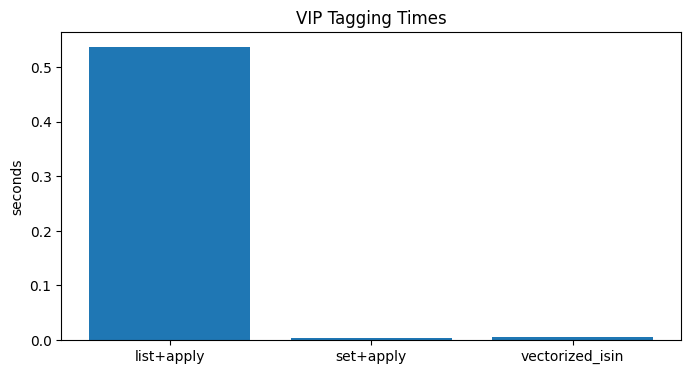

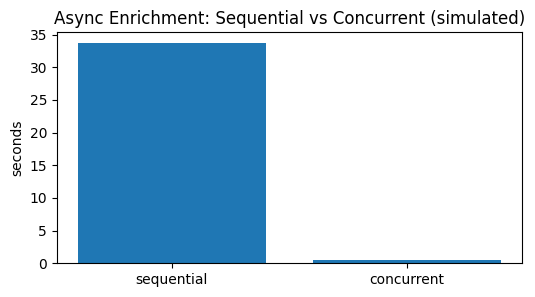

In [12]:
# Cell 5 — Show benchmark bar chart for VIP tagging + enrichment
methods = ["list+apply", "set+apply", "vectorized_isin"]
times = [t_a, t_b, t_c]

plt.figure(figsize=(8,4))
plt.bar(methods, times)
plt.title("VIP Tagging Times")
plt.ylabel("seconds")
plt.show()

# Show enrichment sequential vs concurrent
plt.figure(figsize=(6,3))
plt.bar(["sequential", "concurrent"], [seq_t, conc_t])
plt.title("Async Enrichment: Sequential vs Concurrent (simulated)")
plt.ylabel("seconds")
plt.show()


| Method          | Time      | Reason           |
| --------------- | --------- | ---------------- |
| list + apply    | ❌ slow    | O(n) list search |
| vectorized isin | ⚡ fast    | optimized C code |
| set membership  | ⚡ fastest | O(1) lookup      |


from_records (note the s) is a Pandas DataFrame constructor method.

It lets you create a DataFrame from a list of dictionaries or tuples.